In [32]:
%matplotlib inline 
import matplotlib.pylab as plt 
import numpy as np 
import pandas as pd 
import seaborn as sns 
from xgboost import XGBClassifier
import sklearn.metrics as sklm
import sklearn.model_selection as ms

In [33]:
def print_metrics(labels, scores):
    metrics = sklm.precision_recall_fscore_support(labels, scores,labels=[1,0])
    conf = sklm.confusion_matrix(labels, scores, labels=[1,0])
    print('                 Confusion matrix')
    print('                 Score positive    Score negative')
    print('Actual positive    %6d' % conf[0,0] + '             %5d' % conf[0,1])
    print('Actual negative    %6d' % conf[1,0] + '             %5d' % conf[1,1])
    print('')
    print('Accuracy  %0.2f' % sklm.accuracy_score(labels, scores))
    print(' ')
    print('           Positive      Negative')
    print('Num case   %6d' % metrics[3][0] + '        %6d' % metrics[3][1])
    print('Precision  %6.2f' % metrics[0][0] + '        %6.2f' % metrics[0][1])
    print('Recall     %6.2f' % metrics[1][0] + '        %6.2f' % metrics[1][1])
    print('F1         %6.2f' % metrics[2][0] + '        %6.2f' % metrics[2][1])

In [34]:
def get_feature_importances(model,colnames,n):
    feature_importances = pd.DataFrame()
    feature_importances['features'] = colnames
    feature_importances['importance'] = model.feature_importances_ 
    feature_importances.sort_values(by='importance',ascending=False, inplace=True)
    feature_importances.reset_index(drop=True,inplace=True)
    feature_importances.set_index('features').iloc[0:n].plot(kind='bar',
                                                            figsize=(8,3))
    plt.xticks(rotation='vertical')
    return feature_importances.head(n)

In [35]:
#filename = './datasets/Uganda_seasonal_normalized.csv'
filename = './datasets/Uganda_seasonal_normalized_mean.csv'
data = pd.read_csv(filename)
data['Is_drought'] = data.drought_reported>0
data.head()

,District,year,Season,EVI_mean,NDVI_mean,SoilMoisture00_10cm_mean,SoilMoisture100_200cm_mean,SoilMoisture10_40cm_mean,SoilMoisture40_100cm_mean,SoilTemperature00_10cm_mean,...,precipitation_per_hour_v2_mean,rainfall_mean,surface_temperature_daytime_mean,surface_temperature_nighttime_mean,wind_speed_mean,SPEI_3month_lag1,drought_reported,drought_news_article,drought_desinventar,Is_drought
0,ABIM,2000,11_12,0.635496,0.232554,0.876312,0.199678,0.736812,0.605763,-0.619369,...,-0.469460,1.336204,-0.151764,-1.343323,-0.412148,0.946693,0,0,0,False
1,ABIM,2001,11_12,-0.087761,-0.109488,0.493821,0.183495,0.532963,0.545170,-0.342333,...,-0.254581,0.823853,-0.334808,-0.132387,-1.004612,1.014671,0,0,0,False
2,ABIM,2002,11_12,-1.376630,-1.645360,-1.512378,-1.487177,-1.611315,-1.905963,1.363756,...,-1.405233,-0.482233,2.041320,0.780647,0.752253,0.714817,0,0,0,False
3,ABIM,2003,11_12,0.271856,0.277573,-0.653029,-0.338649,-0.424325,-0.103768,0.496371,...,-1.661421,-1.335585,0.161190,0.848854,1.321092,-1.517769,0,0,0,False
4,ABIM,2004,11_12,-0.947108,-1.454412,-1.207277,-0.974946,-0.705645,-0.739778,0.922325,...,-1.550847,-0.415216,0.949508,-0.042240,0.929712,0.386794,0,0,0,False


In [36]:
id_cols = ['year','District','Season']

label_name = 'Is_drought'

All_label_list = ['drought_reported', 'drought_news_article', 'drought_desinventar', 'Is_drought']

label_name = 'Is_drought'

All_features = list(data.drop(labels=['District','year','Season']+All_label_list, 
                                  axis=1).columns)

# selected_features = ['EVI_mean',
#  'SPEI_3month_lag1',
#  'SoilMoisture00_10cm_mean',
#  'SoilMoisture10_40cm_mean',
#  'SoilTemperature00_10cm_mean',
#  'SoilTemperature10_40cm_mean',
#  'precipitation_per_hour_v2_mean',
#  'surface_temperature_daytime_mean']

selected_features = ['EVI_mean',
 'NDVI_mean',
 'SoilMoisture00_10cm_mean',
 'SoilMoisture100_200cm_mean',
 'SoilMoisture10_40cm_mean',
 'SoilMoisture40_100cm_mean',
 'SoilTemperature00_10cm_mean',
 'SoilTemperature100_200cm_mean',
 'SoilTemperature10_40cm_mean',
 'SoilTemperature40_100cm_mean',
 'air_temperature_mean',
 'evapotranspiration_mean',
 'precipitation_per_hour_v1_mean',
 'precipitation_per_hour_v2_mean',
 'rainfall_mean',
 'surface_temperature_daytime_mean',
 'surface_temperature_nighttime_mean',
 'wind_speed_mean',
 'SPEI_3month_lag1']

#selected_features = All_features

In [37]:
reduced_data = pd.DataFrame()

for name,group in data.groupby('District'):
    drought_years = np.array(group[group[label_name]]['year'])
    keep_years = np.sort(np.unique(np.append(drought_years, [drought_years-1, drought_years+1])))
    temp = group[group.year.apply(lambda x: x in keep_years)].sort_values(by=['year', 'Season']).copy()
    reduced_data = pd.concat([reduced_data, temp])

reduced_data.reset_index(drop=True,inplace=True)

reduced_data

,District,year,Season,EVI_mean,NDVI_mean,SoilMoisture00_10cm_mean,SoilMoisture100_200cm_mean,SoilMoisture10_40cm_mean,SoilMoisture40_100cm_mean,SoilTemperature00_10cm_mean,...,precipitation_per_hour_v2_mean,rainfall_mean,surface_temperature_daytime_mean,surface_temperature_nighttime_mean,wind_speed_mean,SPEI_3month_lag1,drought_reported,drought_news_article,drought_desinventar,Is_drought
0,ABIM,2008,11_12,0.472112,0.433406,-0.299935,-0.401658,-0.513232,-0.373943,0.023236,...,0.410969,-1.040561,-0.863988,0.257548,-0.612212,-0.956344,0,0,0,False
1,ABIM,2008,6_7,-0.777660,-0.791877,-1.087030,-0.125215,-1.219722,-0.580102,0.439307,...,-1.185724,-1.264110,0.536434,-0.633266,0.620304,-1.891516,0,0,0,False
2,ABIM,2009,11_12,-0.959034,-0.776766,-1.828673,-1.776568,-2.402835,-2.509079,1.557044,...,-0.086266,-1.469191,0.695129,1.286431,0.241868,-0.076895,0,0,0,False
3,ABIM,2009,6_7,-0.120184,-0.124127,-0.739839,-0.331838,-0.530722,-0.566959,0.340174,...,-1.107978,-0.534604,-0.054718,0.841467,0.525038,-0.231664,1,0,1,True
4,ABIM,2010,11_12,-0.392718,-0.499785,0.371432,-0.556741,0.039433,0.004917,-0.270119,...,-0.157900,-0.071552,-0.416993,-0.514385,-0.869060,-0.565711,0,0,0,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
361,ZOMBO,2008,6_7,0.214773,0.153118,-1.859536,-1.198422,-2.015221,-1.832033,0.628148,...,-0.255114,-2.084574,-0.593314,-0.605235,-0.070227,-1.785325,0,0,0,False
362,ZOMBO,2009,11_12,-0.290805,-1.009758,-3.065165,-2.656704,-3.099320,-3.130685,1.730749,...,0.490798,-2.746914,1.026036,0.295994,1.210698,-1.801010,0,0,0,False
363,ZOMBO,2009,6_7,-0.834401,-0.756735,-1.599447,-1.240679,-1.664688,-1.524388,0.569586,...,-1.583708,-1.666039,0.581066,-0.022231,0.534914,-1.037791,1,0,1,True
364,ZOMBO,2010,11_12,1.429415,0.720226,0.280299,0.131955,0.266445,0.234409,-0.131787,...,-0.062517,0.635184,1.113469,-1.335018,-0.370430,0.534852,0,0,0,False


In [38]:
input_data = reduced_data[id_cols+selected_features+[label_name]].copy()
input_data.sort_values('year',inplace=True)
input_data.reset_index(drop=True,inplace=True)
input_data.dropna(inplace=True)
input_data

,year,District,Season,EVI_mean,NDVI_mean,SoilMoisture00_10cm_mean,SoilMoisture100_200cm_mean,SoilMoisture10_40cm_mean,SoilMoisture40_100cm_mean,SoilTemperature00_10cm_mean,...,air_temperature_mean,evapotranspiration_mean,precipitation_per_hour_v1_mean,precipitation_per_hour_v2_mean,rainfall_mean,surface_temperature_daytime_mean,surface_temperature_nighttime_mean,wind_speed_mean,SPEI_3month_lag1,Is_drought
0,2000,DOKOLO,11_12,-0.085955,-0.615645,-0.199107,-0.740211,-0.180477,-0.205844,-0.414001,...,-0.853848,-0.647759,1.904310,0.280669,-0.161293,0.140544,-0.922337,-0.131956,0.189763,False
1,2000,MASINDI,11_12,-1.296386,-2.304437,-0.919349,-1.213759,-0.880634,-0.935053,-0.187109,...,-0.789742,-1.578402,2.144540,-0.778523,-1.544820,0.037232,-2.122282,-1.492505,-1.087517,False
2,2000,MASINDI,6_7,-2.969953,-3.113392,-1.393060,-0.757532,-1.166697,-0.863900,1.133581,...,1.294875,-0.677254,0.451625,-2.237257,-0.735258,2.460373,-1.816256,0.457154,-0.512274,True
3,2000,KASESE,11_12,-0.712139,-0.018807,-0.153522,-0.720564,-0.049167,-0.688343,-0.029035,...,-0.380851,-0.049600,1.494947,0.017421,-0.073514,1.187157,-1.138901,0.210982,-0.146508,False
4,2000,KASESE,6_7,-1.974055,-2.617425,-1.513085,-0.756898,-1.512774,-0.897981,0.898668,...,1.417929,-0.684287,0.247437,-2.053752,-0.927083,1.907032,-0.739260,0.704713,-1.016530,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
357,2018,NTUNGAMO,6_7,0.749622,0.398297,2.830922,1.309827,2.446966,2.430016,-2.755016,...,-2.397657,0.957686,3.065183,2.591587,2.863157,-2.141072,0.591278,-2.037848,2.048816,False
358,2019,OMORO,6_7,-1.285719,-1.654123,-0.438191,-0.032317,0.006169,0.018189,1.595897,...,1.552605,-0.774235,-0.869827,-0.185100,-0.407676,2.397035,2.122458,0.617182,0.106191,True
360,2019,DOKOLO,6_7,-1.306607,-1.341924,-0.540027,-0.163110,-0.252585,-0.220921,1.700186,...,1.539429,-0.953299,-0.986904,0.727928,-0.504922,2.319498,2.375864,0.888773,-0.028124,False
362,2019,ABIM,6_7,-1.406211,-1.379266,-1.266873,-0.175845,-0.819886,-0.484497,1.668288,...,1.539716,-1.652902,-1.308559,-0.780224,-1.257818,2.223379,2.362509,1.102652,-0.870391,True


In [39]:
droughts_number = input_data[label_name].sum()
negative_data = input_data[input_data[label_name]==False].copy()
positive_data = input_data[input_data[label_name]==True].copy()
balanced_data = pd.concat([negative_data.sample(n=droughts_number,replace=False,
                                random_state=10,axis=0), positive_data])
balanced_data.sort_values('year',inplace=True)
balanced_data.reset_index(drop=True, inplace=True)
balanced_data[label_name] = balanced_data[label_name].astype(int)
balanced_data

,year,District,Season,EVI_mean,NDVI_mean,SoilMoisture00_10cm_mean,SoilMoisture100_200cm_mean,SoilMoisture10_40cm_mean,SoilMoisture40_100cm_mean,SoilTemperature00_10cm_mean,...,air_temperature_mean,evapotranspiration_mean,precipitation_per_hour_v1_mean,precipitation_per_hour_v2_mean,rainfall_mean,surface_temperature_daytime_mean,surface_temperature_nighttime_mean,wind_speed_mean,SPEI_3month_lag1,Is_drought
0,2000,KASESE,6_7,-1.974055,-2.617425,-1.513085,-0.756898,-1.512774,-0.897981,0.898668,...,1.417929,-0.684287,0.247437,-2.053752,-0.927083,1.907032,-0.739260,0.704713,-1.016530,1
1,2000,MASINDI,6_7,-2.969953,-3.113392,-1.393060,-0.757532,-1.166697,-0.863900,1.133581,...,1.294875,-0.677254,0.451625,-2.237257,-0.735258,2.460373,-1.816256,0.457154,-0.512274,1
2,2000,MBARARA,6_7,-0.380934,-0.042467,-1.227326,-1.138666,-1.680736,-1.136998,0.771363,...,1.246203,-0.688399,0.609185,-0.955307,-0.379737,-0.053899,-1.960281,0.213589,0.390858,1
3,2001,DOKOLO,11_12,0.272306,0.158321,0.296197,0.159720,0.295555,0.286197,-0.323444,...,-0.559270,0.008007,0.747152,-0.178855,0.587292,-0.354477,-0.786848,0.488809,0.882221,0
4,2001,DOKOLO,6_7,0.722355,0.503847,0.733783,-0.451693,0.264317,0.026751,-0.170350,...,0.401262,1.771671,2.024965,0.208111,1.492109,-0.288953,-0.915164,-0.445286,1.090399,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
125,2018,DOKOLO,6_7,1.961242,1.396662,2.787802,1.822198,2.090908,1.837908,-2.986651,...,-3.057041,0.466941,2.224787,2.646489,2.755269,-2.256689,-1.410187,-1.998573,2.222061,1
126,2018,ISINGIRO,6_7,0.566537,0.437719,2.463306,0.770911,2.018868,2.039828,-2.283106,...,-2.111027,0.770325,2.227573,2.143520,2.344231,-1.416090,-0.366104,-1.287745,1.904654,0
127,2019,ABIM,6_7,-1.406211,-1.379266,-1.266873,-0.175845,-0.819886,-0.484497,1.668288,...,1.539716,-1.652902,-1.308559,-0.780224,-1.257818,2.223379,2.362509,1.102652,-0.870391,1
128,2019,OMORO,6_7,-1.285719,-1.654123,-0.438191,-0.032317,0.006169,0.018189,1.595897,...,1.552605,-0.774235,-0.869827,-0.185100,-0.407676,2.397035,2.122458,0.617182,0.106191,1


In [40]:
L=len(balanced_data)
p1=0.85
p2=0.8
train_val_ind = list(range(int(p1*L)))
test_ind = list(range(np.max(train_val_ind)+1,L))
L2 = len(train_val_ind)
train_ind = list(range(int(p2*L2)))
val_ind = list(range(np.max(train_ind)+1,L2))

In [41]:
len(train_ind)

88

In [42]:
balanced_data.loc[train_ind][label_name].sum()/len(train_ind)

0.5

In [43]:
balanced_data.loc[val_ind][label_name].sum()/len(val_ind)

0.45454545454545453

In [44]:
balanced_data.loc[test_ind][label_name].sum()/len(test_ind)

0.55

## Train a model with default setting 

In [45]:
model=XGBClassifier()

X = balanced_data[selected_features]
y = balanced_data[label_name]

X_train = balanced_data[selected_features].loc[train_ind]
y_train = balanced_data[label_name].loc[train_ind]

X_val = balanced_data[selected_features].loc[val_ind]
y_val = balanced_data[label_name].loc[val_ind]

X_test = balanced_data[selected_features].loc[test_ind]
y_test = balanced_data[label_name].loc[test_ind]

model.fit(X_train,y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

In [46]:
y_pred = model.predict(X_val)

In [47]:
print_metrics(y_val, y_pred)

                 Confusion matrix
                 Score positive    Score negative
Actual positive         5                 5
Actual negative         3                 9

Accuracy  0.64
 
           Positive      Negative
Num case       10            12
Precision    0.62          0.64
Recall       0.50          0.75
F1           0.56          0.69


,features,importance
0,SoilTemperature10_40cm_mean,0.163933
1,SoilTemperature00_10cm_mean,0.084691
2,SoilTemperature100_200cm_mean,0.072307
3,precipitation_per_hour_v2_mean,0.068383
4,air_temperature_mean,0.068193
5,rainfall_mean,0.066343
6,surface_temperature_nighttime_mean,0.065907
7,SoilMoisture40_100cm_mean,0.063394
8,wind_speed_mean,0.049424
9,SoilTemperature40_100cm_mean,0.046854


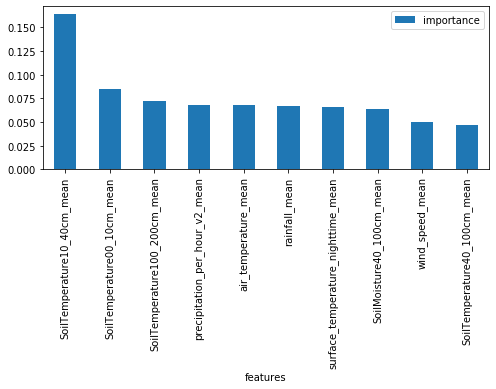

In [48]:
get_feature_importances(model,selected_features,10)

## Optimizing Model

In [49]:
def do_gridsearch(X,y,opt_model,param_grid,cv,scoring):
    GS = ms.GridSearchCV(estimator = opt_model, param_grid = param_grid, 
                              cv = cv,
                              scoring = scoring,
                              return_train_score = True,n_jobs=4)
    GS.fit(X,y);
    
    for key in param_grid.keys():
        exec("opt_model." + key + "= GS.best_params_[key]")

    print(GS.best_params_)
    print(scoring + ' = ',GS.best_score_)
    
    return opt_model

In [50]:
opt_model=XGBClassifier()
cv = ((np.array(train_ind),np.array(val_ind)),)
scoring = 'f1_macro'

### Optimizing 'max_depth' and 'min_child_weight'

In [51]:
param_grid = {'max_depth':range(1,25,1),
                       'min_child_weight':[2,4,6,8,10,20,30,40,50]}

opt_model = do_gridsearch(X,y,opt_model,param_grid,cv,scoring)

{'max_depth': 1, 'min_child_weight': 8}
f1_macro =  0.725


### Optimizing gamma

In [52]:
param_grid = {'gamma':[i/100.0 for i in range(0,100)]}

opt_model = do_gridsearch(X,y,opt_model,param_grid,cv,scoring)

{'gamma': 0.0}
f1_macro =  0.725


### Optimizing subsample and colsample_bytree

In [53]:
param_grid = {'subsample':[i/10.0 for i in range(6,11)],
                       'colsample_bytree':[i/10.0 for i in range(6,11)]}

opt_model = do_gridsearch(X,y,opt_model,param_grid,cv,scoring)

{'colsample_bytree': 0.6, 'subsample': 0.9}
f1_macro =  0.768421052631579


### Optimizing reg_alpha

In [54]:
param_grid = {'reg_alpha':[1e-5, 1e-2, 0.1, 1, 100]}

opt_model = do_gridsearch(X,y,opt_model,param_grid,cv,scoring)

{'reg_alpha': 1e-05}
f1_macro =  0.768421052631579


### Optimizing learning_rate

In [55]:
param_grid = {'learning_rate':np.arange(0,1,0.01)}
opt_model = do_gridsearch(X,y,opt_model,param_grid,cv,scoring)

{'learning_rate': 0.04}
f1_macro =  0.768421052631579


## Performance on validation

In [56]:
opt_model.fit(X_train,y_train)
y_pred = opt_model.predict(X_val)
print_metrics(y_val, y_pred)

                 Confusion matrix
                 Score positive    Score negative
Actual positive         7                 3
Actual negative         2                10

Accuracy  0.77
 
           Positive      Negative
Num case       10            12
Precision    0.78          0.77
Recall       0.70          0.83
F1           0.74          0.80


## Performance on test

In [57]:
opt_model.fit(X_train,y_train)
y_pred = opt_model.predict(X_test)
print_metrics(y_test, y_pred)

                 Confusion matrix
                 Score positive    Score negative
Actual positive         7                 4
Actual negative         4                 5

Accuracy  0.60
 
           Positive      Negative
Num case       11             9
Precision    0.64          0.56
Recall       0.64          0.56
F1           0.64          0.56


## Training on the whole data

In [58]:
opt_model.fit(X,y)
y_pred = opt_model.predict(X)
print_metrics(y, y_pred)

                 Confusion matrix
                 Score positive    Score negative
Actual positive        48                17
Actual negative        17                48

Accuracy  0.74
 
           Positive      Negative
Num case       65            65
Precision    0.74          0.74
Recall       0.74          0.74
F1           0.74          0.74


,features,importance
0,SoilMoisture00_10cm_mean,0.199322
1,SoilMoisture10_40cm_mean,0.180076
2,rainfall_mean,0.082549
3,SoilTemperature100_200cm_mean,0.080426
4,precipitation_per_hour_v2_mean,0.073793
5,EVI_mean,0.054035
6,SoilMoisture40_100cm_mean,0.051698
7,precipitation_per_hour_v1_mean,0.047899
8,SPEI_3month_lag1,0.045522
9,air_temperature_mean,0.043111


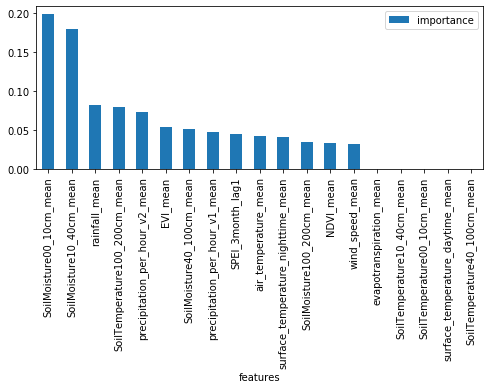

In [63]:
feature_importances = get_feature_importances(opt_model,selected_features,len(selected_features))
feature_importances